# FINAL PROJECT

**The data challenge is available :** https://www.kaggle.com/competitions/lmsys-chatbot-arena/data
   
**My GitHub is available:** https://github.com/lzheng01/LMSYS

## 1. Instroduction

Chatbot Arena hosted a Kaggle competition offering a unique opportunity to address the challenge of aligning LLM capability with human preference using real-world data. Previous research has highlighted the limitations of directly prompting an existing LLM for preference predictions. These limitations often arise biases such as favouring responses presented first, being overly verbose, or exhibiting self-promotion.

The competition utilized data from user interactions on Chatbot Arena, where judges provided one or more prompts to two different large language models and selected the response they found more satisfactory. This dataset provides invaluable insights into user preferences and the underlying factors that influence them, serving as a foundation for advancing LLM alignment and evaluation.

My project focuses on developing a predictive model of user preferences using data collected from head-to-head battles between leading AI chatbots on the Chatbot Arena platform. By analyzing these interactions, the project aims to identify key predictors of user satisfaction and refine methods to better align LLM outputs with human expectations.

In [ ]:
!pip install -q transformers[torch] pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 35.1 MB/s eta 0:00:00


In [ ]:
import time
import warnings
from pathlib import Path
from tqdm import tqdm
from typing import Any, Dict, List, Optional
from IPython.display import display, HTML
from google.colab import drive
import os
import io
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning.callbacks import EarlyStopping

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from tokenizers import AddedToken
import shutil



In [ ]:
# Configuration
warnings.simplefilter("ignore")
sns.set_style("darkgrid")
pd.options.display.max_rows = None
pd.options.display.max_columns = None
colors = sns.color_palette("pastel")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -o -q '/content/drive/My Drive/5511/lmsys-chatbot-arena.zip' -d '/content/data/'

In [ ]:
#label file paths
current_dir = os.getcwd()
path_dir = os.path.join(current_dir, 'data/')
train_path = path_dir + 'train.csv'
test_path = path_dir + 'test.csv'
sample_submission_path = path_dir + 'sample_submission.csv'

In [ ]:
#import data
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_sample_submission = pd.read_csv(sample_submission_path)


________
## 2. Exploratory Analysis (EDA)
_____

### 2.1 Data Overview
This dataset has 2 sepearate csv files, which is train.csv and test.csv.

In [ ]:
# Check training data
# First few rows for train data
df_train.head(3)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1


In [ ]:
# Summary of the dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


In [ ]:
# Check test data
# First few rows for test data
df_test.head(5)

,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


In [ ]:
# Summary of the dataframe
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3 non-null      int64 
 1   prompt      3 non-null      object
 2   response_a  3 non-null      object
 3   response_b  3 non-null      object
dtypes: int64(1), object(3)
memory usage: 224.0+ bytes


There is only 3 rows in test.csv. This is a code competition. Kaggle will take the code from the notebook and run it on the real test data from the backend, then score it based on the true test dataset.

### 2.2 Data Cleaning

In [ ]:
# The shape of train data
print(f"The training DataFrame is {df_train.shape}.")

The training DataFrame is (57477, 9).


#### Dataset Overview

The dataset consists of 57,477 rows in the training data. Each row represents a user interaction where two models (model_a and model_b) provide responses to a prompt.

#### Dataset Size

- **Training Dataset:** 57,477 rows
- **Test Dataset:** 3 rows

This indicates a moderately large dataset, which should allow for robust model training and validation.

#### Data Structure

Each row in the dataset represents a user interaction. The columns include:

- **id:** A unique identifier for each interaction.
- **model[a/b]:** Identifiers for the two models involved in the interaction.
- **prompt:** The input prompt given to both models.
- **response[a/b]:** The responses generated by model_a and model_b respectively.
- **winnermodel[a/b/tie]:** Indicates which model's response was chosen as the winner by the judge.

#### Target Variable

The target variable (**winnermodel[a/b/tie]**) indicating whether model_a, model_b, or a tie was selected as the winner. Predicting this target variable correctly is the objective.


In [ ]:
# Drop id for further analysis
eda_train = df_train.copy()
eda_train = eda_train.drop("id", axis=1)
print(f"After dropping 'id' column, shape of the eda_training DataFrame becomes {eda_train.shape}.")

After dropping 'id' column, shape of the eda_training DataFrame becomes (57477, 8).


In [ ]:
# Duplicates Checking
n_dups = eda_train.duplicated(keep=False).sum()
print(f"There exist {n_dups} duplicated rows.")

n_rows1 = len(eda_train)
eda_train = eda_train.drop_duplicates(keep="first", ignore_index=True)
n_rows2 = len(eda_train)
print(f"After removing duplicates, #samples drops from {n_rows1} to {n_rows2}.")

There exist 14 duplicated rows.
After removing duplicates, #samples drops from 57477 to 57470.


### 2.3 Data Exploration

In [ ]:
# Explore a single chat from dataset
demo_chat = eda_train.iloc[2]
for col in ["prompt", "response_a", "response_b"]:
    assert isinstance(demo_chat[col], str)

print(f"=== Prompt ===")
print(demo_chat["prompt"], '\n')
print(f"=== Response of {demo_chat['model_a']} ===")
print(demo_chat["response_a"], '\n')
print(f"=== Response of {demo_chat['model_b']} ===")
print(demo_chat["response_b"])
print("-" * 50)
if demo_chat["winner_model_a"]:
    print(f">>> {demo_chat['model_a']} is the winner!!")
elif demo_chat["winner_model_b"]:
    print(f">>> {demo_chat['model_b']} is the winner!!")
else:
    print(f">>> Winner tie!!")

=== Prompt ===
["explain function calling. how would you call a function?"] 

=== Response of gpt-3.5-turbo-0613 ===
["Function calling is the process of invoking or executing a function in a programming language. To call a function, you need to use the function's name followed by parentheses \"()\". Within the parentheses, you can pass arguments if the function requires any.\n\nHere is an example of how to call a function in Python:\n\n```python\n# Define a function\ndef greet(name):\n    print(\"Hello, \" + name + \"!\")\n\n# Call the function\ngreet(\"John\")\n```\n\nIn this example, the function \"greet\" is defined with a single parameter \"name\" which is used to print a greeting message. To call the function and pass an argument, we write \"greet(\"John\")\". This will execute the function and print \"Hello, John!\".\n\nIt is important to note that the function should be defined before calling it in most programming languages, as the interpreter needs to know about the function'

#### Visualizing a sample chat

Referred to the discussion thread https://www.kaggle.com/competitions/lmsys-chatbot-arena/discussion/507784

In [ ]:
TARGETS = ["winner_model_a", "winner_model_b", "winner_tie"]

In [ ]:
class ChatRenderer:

    CSS: str = """
        <style>
            lm-chat-body {
                display: flex;
                justify-content: center;
                align-items: flex-start;
                margin: 0;
                padding: 20px;
                font-family: Arial, sans-serif;
                background-color: #f5f5f5;
            }
            .lm-chat-container {
                display: flex;
                flex-direction: column;
                width: 100%;
                max-width: 1200px;
                border: 1px solid #ddd;
                box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
                background-color: #fff;
            }
            .lm-chat-panels {
                display: flex;
                width: 100%;
            }
            .lm-chat-panel {
                width: 50%;
                padding: 20px;
                box-sizing: border-box;
                border-right: 1px solid #ddd;
                position: relative;
            }
            .lm-chat-panel:last-child {
                border-right: none;
            }
            .lm-chat-model-header {
                font-weight: bold;
                margin-bottom: 10px;
                font-size: 14px;
                position: absolute;
                top: 10px;
                left: 20px;
                background-color: white;
                padding: 0 5px;
            }
            .lm-chat-prompt {
                background-color: #fdf5e6;
                padding: 10px;
                margin-top: 30px;
                margin-bottom: 20px;
                border-radius: 5px;
                border: 1px solid #ddd;
            }
            .lm-chat-response {
                background-color: #fff;
                padding: 10px;
                margin-bottom: 20px;
                border-radius: 5px;
                border: 1px solid #ddd;
            }
            .lm-chat-winner {
                text-align: center;
                padding: 10px;
                border-top: 1px solid #ddd;
                background-color: #f5f5f5;
                font-size: 16px;
            }
        </style>
    """

    def __init__(self, chat: pd.Series) -> None:
        self.model_a, self.model_b = chat["model_a"], chat["model_b"]
        self.prompt = chat["prompt"] if isinstance(chat["prompt"], list) else eval(chat["prompt"])
        self.res_a = chat["response_a"] if isinstance(chat["response_a"], list) else eval(chat["response_a"])
        self.res_b = chat["response_b"] if isinstance(chat["response_b"], list) else eval(chat["response_b"])
        self.targets = chat[TARGETS]

    def display(self, suppress_output: bool = False) -> None:
        if suppress_output:
            with io.capture_output() as captured:
                display(self._gen_html())
        else:
            display(self._gen_html())

    def _gen_html(self) -> HTML:
        html_content = f"""
            <script type="module" src="https://md-block.verou.me/md-block.js"></script>
            <html>
                <lm-chat-body>
                    <div class="lm-chat-container">
                        <div class="lm-chat-panels">
                            {self._gen_panel("a")}
                            {self._gen_panel("b")}
                        </div>
                        <div class="lm-chat-winner">
                            {self._get_winner()}
                        </div>
                    </div>
                </lm-chat-body>
            </html>
        """.encode("utf-16", "surrogatepass").decode("utf-16")

        html = HTML(self.CSS + html_content)

        return html

    def _gen_panel(self, model: str) -> str:
        res = self.res_a if model == "a" else self.res_b
        model_name = self.model_a if model == "a" else self.model_b
        panel = ""
        for p, r in zip(self.prompt, res):
            panel += f"""
                <div class="lm-chat-prompt">
                    <md-block>{p}</md-block>
                </div>
                <div class="lm-chat-response">
                    <md-block>{r}</md-block>
                </div>
            """
        panel = f"""
            <div class="lm-chat-panel">
                <div class="lm-chat-model-header">Model {model.upper()} - {model_name}</div>
                {panel}
            </div>
        """

        return panel

    def _get_winner(self) -> str:
        if self.targets["winner_model_a"]:
            winner = f"Model A - <strong>{self.model_a}</strong> Wins!"
        elif self.targets["winner_model_b"]:
            winner = f"Model B - <strong>{self.model_b}</strong> Wins!"
        else:
            winner = "<strong>Tie!<strong>"

        return winner

In [ ]:
chat_renderer = ChatRenderer(eda_train.iloc[4])
chat_renderer.display()

#### Chat analysis

Text(0, 0.5, 'Prompt')

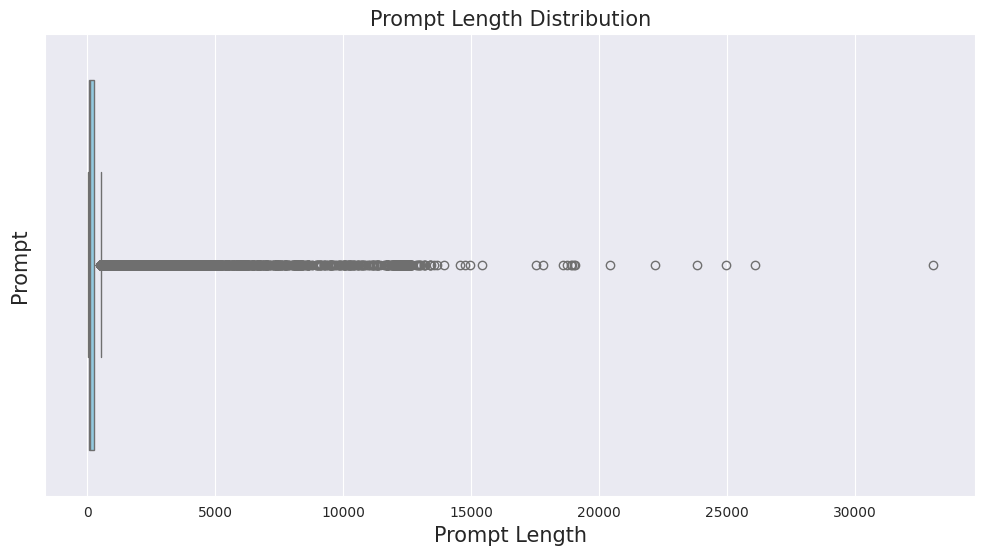

In [ ]:
# Prompt length distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x=eda_train["prompt"].apply(len), color="skyblue")
plt.title("Prompt Length Distribution", fontsize=15)
plt.xlabel("Prompt Length", fontsize=15)
plt.ylabel("Prompt", fontsize=15)

In [ ]:

# Calculate prompt lengths
prompt_lengths = eda_train["prompt"].apply(len)

# Calculate Q1, Q3, and Mean
Q1 = np.percentile(prompt_lengths, 25)
Q3 = np.percentile(prompt_lengths, 75)
MEAN = np.mean(prompt_lengths)

print("Q1 (25th percentile):", Q1)
print("Q3 (75th percentile):", Q3)
print("Mean Prompt Length:", MEAN)

Q1 (25th percentile): 52.0
Q3 (75th percentile): 243.0
Mean Prompt Length: 369.2060553332173


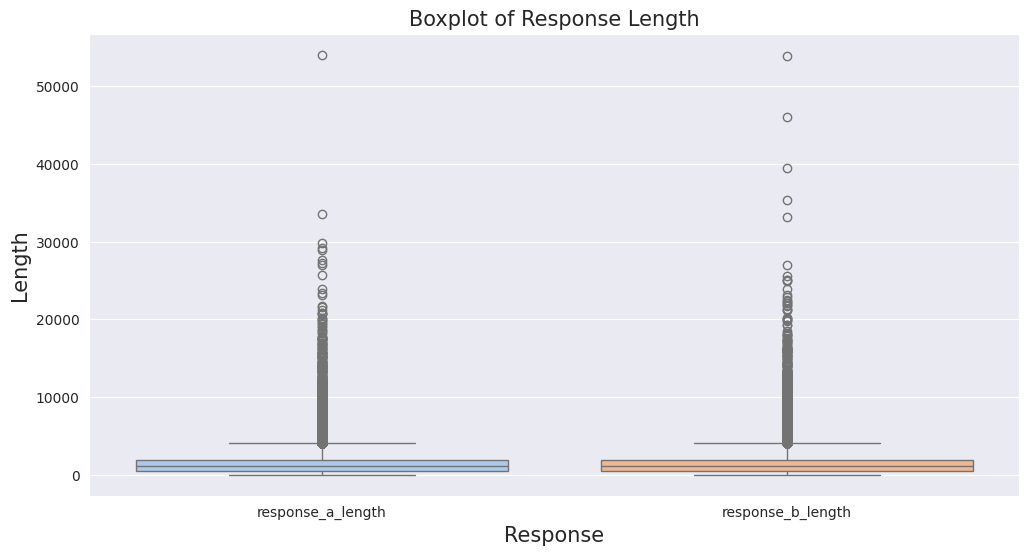

In [ ]:
# Response length distribution
eda_train['response_a_length'] = eda_train['response_a'].apply(len)
eda_train['response_b_length'] = eda_train['response_b'].apply(len)
eda_melted = eda_train.melt(value_vars=['response_a_length', 'response_b_length'], var_name='response', value_name='length')
plt.figure(figsize=(12, 6))
colors = sns.color_palette("pastel")
sns.boxplot(x='response', y='length', data=eda_melted, palette=colors)
plt.title("Boxplot of Response Length", fontsize=15)
plt.xlabel("Response", fontsize=15)
plt.ylabel("Length", fontsize=15)
plt.show()


####Check the most frequent model

In [ ]:
# Check model types
models =['model_a', 'model_b']

for model in models:
    model_ = sorted(list(eda_train[model].unique()))
    print("="*80)
    print(f'The number of {model}:')
    print(len(model_))
    print(f'The name of {model}:')
    print(model_)
    print(' '*80)


The number of model_a:
64
The name of model_a:
['RWKV-4-Raven-14B', 'alpaca-13b', 'chatglm-6b', 'chatglm2-6b', 'chatglm3-6b', 'claude-1', 'claude-2.0', 'claude-2.1', 'claude-instant-1', 'codellama-34b-instruct', 'deepseek-llm-67b-chat', 'dolly-v2-12b', 'dolphin-2.2.1-mistral-7b', 'falcon-180b-chat', 'fastchat-t5-3b', 'gemini-pro', 'gemini-pro-dev-api', 'gpt-3.5-turbo-0125', 'gpt-3.5-turbo-0314', 'gpt-3.5-turbo-0613', 'gpt-3.5-turbo-1106', 'gpt-4-0125-preview', 'gpt-4-0314', 'gpt-4-0613', 'gpt-4-1106-preview', 'gpt4all-13b-snoozy', 'guanaco-33b', 'koala-13b', 'llama-13b', 'llama-2-13b-chat', 'llama-2-70b-chat', 'llama-2-7b-chat', 'llama2-70b-steerlm-chat', 'mistral-7b-instruct', 'mistral-7b-instruct-v0.2', 'mistral-medium', 'mixtral-8x7b-instruct-v0.1', 'mpt-30b-chat', 'mpt-7b-chat', 'nous-hermes-2-mixtral-8x7b-dpo', 'oasst-pythia-12b', 'openchat-3.5', 'openchat-3.5-0106', 'openhermes-2.5-mistral-7b', 'palm-2', 'pplx-70b-online', 'pplx-7b-online', 'qwen-14b-chat', 'qwen1.5-4b-chat', 'qw

In [ ]:
# Confirm that model_a and model_b have same unique models
assert sorted(list(eda_train['model_a'].unique())) == sorted(list(eda_train['model_b'].unique()))


In [ ]:
df_btl = (
    eda_train.groupby(["model_a", "model_b"], as_index=False)
    .agg({"prompt": "count", **{winner: "sum" for winner in TARGETS}})
    .rename({"prompt": "battle_cnt"}, axis=1)
    .sort_values("battle_cnt", ascending=False)
    .reset_index(drop=True)
)
df_btl.head()

,model_a,model_b,battle_cnt,winner_model_a,winner_model_b,winner_tie
0,claude-2.1,gpt-4-1106-preview,557,106,317,134
1,gpt-4-1106-preview,claude-2.1,516,302,98,116
2,gpt-4-1106-preview,gpt-4-0613,502,226,109,167
3,gpt-4-0613,gpt-4-1106-preview,480,113,225,142
4,claude-2.1,claude-1,412,120,146,146


In [ ]:
# Self-join on model pairs where model_a matches model_b and model_b matches model_a in reverse
df_btl = df_btl.merge(
    df_btl,
    left_on=['model_a', 'model_b'],
    right_on=['model_b', 'model_a'],
    suffixes=('_left', '_right')
)

df_btl['combined_battle_cnt'] = df_btl['battle_cnt_left'] + df_btl['battle_cnt_right']
df_btl['combined_winner_model_a'] = df_btl['winner_model_a_left'] + df_btl['winner_model_b_right']
df_btl['combined_winner_model_b'] = df_btl['winner_model_b_left'] + df_btl['winner_model_a_right']
df_btl['combined_winner_tie'] = df_btl['winner_tie_left'] + df_btl['winner_tie_right']
df_btl = df_btl.drop_duplicates(subset=['model_a_left', 'model_b_left'])

df_btl['pair'] = df_btl.apply(lambda row: tuple(sorted([row['model_a_left'], row['model_b_left']])), axis=1)
df_btl = df_btl.drop_duplicates(subset=['pair'])
df_btl = df_btl[['model_a_left', 'model_b_left', 'combined_battle_cnt', 'combined_winner_model_a', 'combined_winner_model_b', 'combined_winner_tie']]
df_btl.rename(columns={
    'model_a_left': 'model_a',
    'model_b_left': 'model_b',
    'combined_battle_cnt': 'battle_cnt',
    'combined_winner_model_a': 'winner_model_a',
    'combined_winner_model_b': 'winner_model_b',
    'combined_winner_tie': 'winner_tie'
}, inplace=True)

df_btl.head()


,model_a,model_b,battle_cnt,winner_model_a,winner_model_b,winner_tie
0,claude-2.1,gpt-4-1106-preview,1073,204,619,250
2,gpt-4-1106-preview,gpt-4-0613,982,451,222,309
4,claude-2.1,claude-1,763,195,276,292
5,claude-2.1,gpt-4-0613,758,221,348,189
6,gpt-3.5-turbo-0613,gpt-4-1106-preview,707,99,429,179


In [ ]:
def get_total_wins(df, model_name):
    wins_as_a = df[df['model_a'] == model_name]['winner_model_a'].sum()
    wins_as_b = df[df['model_b'] == model_name]['winner_model_b'].sum()
    total_wins = wins_as_a + wins_as_b
    return total_wins

In [ ]:
models = sorted(list(eda_train['model_a'].unique()))
total_wins = {model: get_total_wins(df_btl, model) for model in models}
total_wins = sorted(total_wins.items(), key=lambda item: item[1], reverse=True)

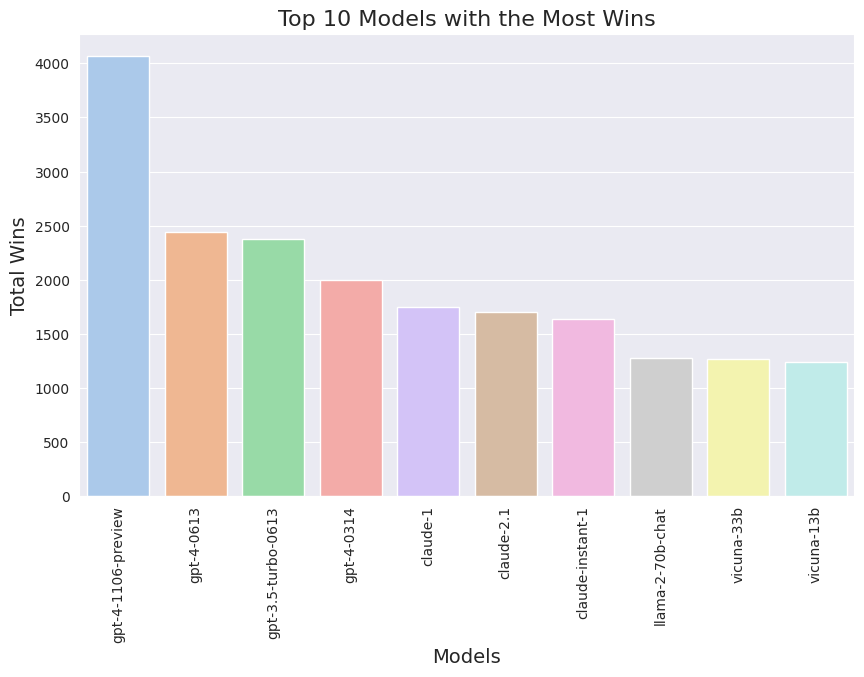

In [ ]:
# Show the top 10 models with the most wins
top_10_models = total_wins[:10]
models, wins = zip(*top_10_models)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=models, y=wins, palette=colors, ax=ax)
ax.set_title("Top 10 Models with the Most Wins", fontsize=16)
ax.set_xlabel("Models", fontsize=14)
ax.set_ylabel("Total Wins", fontsize=14)
ax.tick_params(axis='x', rotation=90)
plt.show()


However, simply looking at the models with the most wins doesn't provide a complete picture. We need to consider the win ratio, which is calculated by dividing the total wins by the total number of battles.

In [ ]:
def get_total_win_ratio(df, model_name):
    wins_as_a = df[df['model_a'] == model_name]['winner_model_a'].sum()
    wins_as_b = df[df['model_b'] == model_name]['winner_model_b'].sum()
    total_wins = wins_as_a + wins_as_b
    battles_as_a = df[df['model_a'] == model_name]['battle_cnt'].sum()
    battles_as_b = df[df['model_b'] == model_name]['battle_cnt'].sum()
    total_battles = battles_as_a + battles_as_b
    win_ratio = total_wins / total_battles if total_battles > 0 else 0
    return win_ratio


In [ ]:
total_win_ratio = {model: get_total_win_ratio(df_btl, model) for model in models}
total_win_ratio = sorted(total_win_ratio.items(), key=lambda item: item[1], reverse=True)

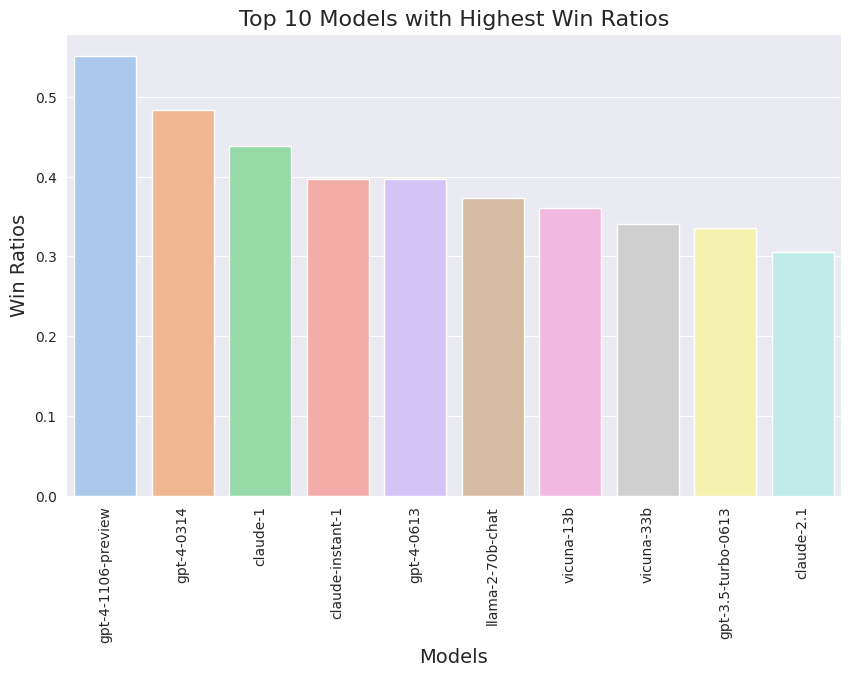

In [ ]:
# Show the top 10 models with highest win ratios
top_10_models = total_win_ratio[:10]
models, wins = zip(*top_10_models)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=models, y=wins, palette=colors, ax=ax)
ax.set_title("Top 10 Models with Highest Win Ratios", fontsize=16)
ax.set_xlabel("Models", fontsize=14)
ax.set_ylabel("Win Ratios", fontsize=14)
ax.tick_params(axis='x', rotation=90)
plt.show()


To gain a clearer understanding of their performance and relationships, a head-to-head heatmap is essential.

In [ ]:
def calculate_win_ratios(df):
    win_ratios = pd.DataFrame()

    models = list(set(df['model_a']).union(set(df['model_b'])))

    for model in models:
        win_ratios[model] = 0.0

    for _, row in df.iterrows():
        model_a, model_b = row['model_a'], row['model_b']
        battle_cnt = row['battle_cnt']
        winner_model_a, winner_model_b = row['winner_model_a'], row['winner_model_b']

        if battle_cnt > 0:
            win_ratios.loc[model_a, model_b] = winner_model_a / battle_cnt
            win_ratios.loc[model_b, model_a] = winner_model_b / battle_cnt

    return win_ratios

def plot_heatmap(win_ratios, top_n=10):
    overall_win_ratios = win_ratios.sum(axis=1) / (win_ratios != 0).sum(axis=1)
    top_models = overall_win_ratios.nlargest(top_n).index

    top_win_ratios = win_ratios.loc[top_models, top_models]

    plt.figure(figsize=(12, 10))
    sns.heatmap(top_win_ratios, annot=True, cmap="YlGnBu", linewidths=.5)
    plt.title(f'Win Ratios Heatmap for Top {top_n} Models')
    plt.show()


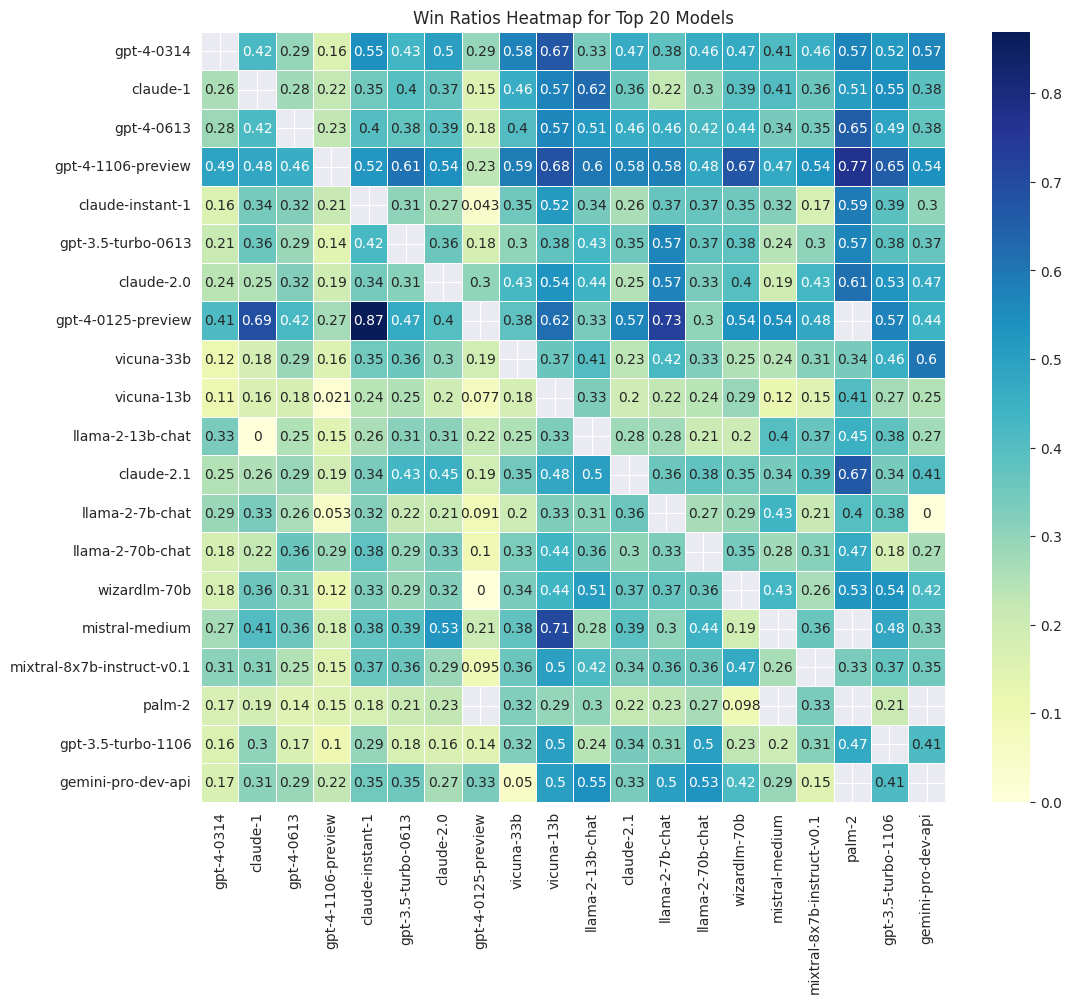

In [ ]:
# Calculate win ratios
win_ratios = calculate_win_ratios(df_btl)

# Plot heatmap for top 20 models
plot_heatmap(win_ratios, top_n=20)

The heatmap illustrates the win ratios of the top 20 models in the Chatbot Arena competition. Each cell in the heatmap represents the win ratio of the model in the row against the model in the column. The color intensity of each cell indicates the win ratio, with darker colors representing higher win ratios.


1. **GPT-4 Models' Dominance**:
   - The GPT-4 models (`gpt-4-0314`, `gpt-4-0613`, `gpt-4-1106-preview`, `gpt-4-0125-preview`) consistently show high win ratios against other models. For example, `gpt-4-0125-preview` has a win ratio of 0.87 against `claude-instant-1` and 0.69 against `claude-1`.
   
2. **Consistent Performance**:
   - `claude-instant-1` and `claude-2.0` also demonstrate strong performance with notable win ratios against several other models, except GPT-4 models.   

The heatmap provides a clear visual representation of head-to-head performance, helping to understand the relative strengths of each model. For example, `mistral-medium` has a strong win ratio of 0.71 against `vicuna-13b` but only 0.19 against `wizardlm-70b`.

### 2.4 Data preparation for training

In [ ]:
def add_label(df):
    labels = np.zeros(len(df), dtype=np.int32)
    labels[df['winner_model_a'] == 1] = 0
    labels[df['winner_model_b'] == 1] = 1
    labels[df['winner_tie'] == 1] = 2
    df['label'] = labels
    return df


def add_stats(df):
    # Some stats
    df["prompt_words"] = df["prompt"].apply(lambda x: x.replace('\n', ' ').split(" "))
    df["total_prompt_words"] = df["prompt"].apply(lambda x: len(x.split(" ")))
    df["prompt_length"] = df["prompt"].apply(lambda x: len(x))

    df["response_a_words"] = df["response_a"].apply(lambda x: x.replace('\n', ' ').split(" "))
    df["total_response_a_words"] = df["response_a"].apply(lambda x: len(x.split(" ")))
    df["response_a_length"] = df["response_a"].apply(lambda x: len(x))

    df["response_b_words"] = df["response_b"].apply(lambda x: x.replace('\n', ' ').split(" "))
    df["total_response_b_words"] = df["response_b"].apply(lambda x: len(x.split(" ")))
    df["response_b_length"] = df["response_b"].apply(lambda x: len(x))

    return df

def truncate_text(df, column_name, max_length=512):
    df[f"{column_name}"] = df[column_name].str[:max_length]
    return df



In [ ]:
df_train = add_label(df_train)
df_train = add_stats(df_train)
df_train = truncate_text(df_train, 'prompt')
df_train = truncate_text(df_train, 'response_a')
df_train = truncate_text(df_train, 'response_b')
df_train.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,label,prompt_words,total_prompt_words,prompt_length,response_a_words,total_response_a_words,response_a_length,response_b_words,total_response_b_words,response_b_length
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0,"[[""Is, it, morally, right, to, try, to, have, ...",28,165,"[[""The, question, of, whether, it, is, morally...",656,4538,"[[""As, an, AI,, I, don't, have, personal, beli...",204,1206
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1,"[[""What, is, the, difference, between, marriag...",35,200,"[[""A, marriage, license, is, a, legal, documen...",537,3114,"[[""A, marriage, license, and, a, marriage, cer...",591,3649
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,2,"[[""explain, function, calling., how, would, yo...",9,60,"[[""Function, calling, is, the, process, of, in...",141,921,"[[""Function, calling, is, the, process, of, in...",282,1835
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,0,"[[""How, can, I, create, a, test, set, for, a, ...",18,87,"[[""Creating, a, test, set, for, a, very, rare,...",536,3182,"[[""When, building, a, classifier, for, a, very...",265,1562
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1,"[[""What, is, the, best, way, to, travel, from,...",14,79,"[[""The, best, way, to, travel, from, Tel, Aviv...",236,1300,"[[""The, best, way, to, travel, from, Tel-Aviv,...",122,772


In [ ]:
# prompt: show max length for df['prompt'], df['response_a'], df['response_b']

print(f"max length of ['prompt']: {df_train['prompt'].str.len().max()}")
print(f"max length of ['response_a']: {df_train['response_a'].str.len().max()}")
print(f"max length of ['response_b']: {df_train['response_b'].str.len().max()}")


max length of ['prompt']: 512
max length of ['response_a']: 512
max length of ['response_b']: 512


In [ ]:
data = df_train.copy()
data["label"] = data["label"].astype('int32')
data.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,label,prompt_words,total_prompt_words,prompt_length,response_a_words,total_response_a_words,response_a_length,response_b_words,total_response_b_words,response_b_length
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0,"[[""Is, it, morally, right, to, try, to, have, ...",28,165,"[[""The, question, of, whether, it, is, morally...",656,4538,"[[""As, an, AI,, I, don't, have, personal, beli...",204,1206
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1,"[[""What, is, the, difference, between, marriag...",35,200,"[[""A, marriage, license, is, a, legal, documen...",537,3114,"[[""A, marriage, license, and, a, marriage, cer...",591,3649
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,2,"[[""explain, function, calling., how, would, yo...",9,60,"[[""Function, calling, is, the, process, of, in...",141,921,"[[""Function, calling, is, the, process, of, in...",282,1835
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,0,"[[""How, can, I, create, a, test, set, for, a, ...",18,87,"[[""Creating, a, test, set, for, a, very, rare,...",536,3182,"[[""When, building, a, classifier, for, a, very...",265,1562
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1,"[[""What, is, the, best, way, to, travel, from,...",14,79,"[[""The, best, way, to, travel, from, Tel, Aviv...",236,1300,"[[""The, best, way, to, travel, from, Tel-Aviv,...",122,772


-------
## 3. Model Building and Training
-----




#### Model Overview
The model is based on Microsoft's DeBERTa-v3 architecture, specifically fine-tuned for a sequence classification task. DeBERTa, which stands for **Decoding-enhanced BERT with disentangled attention**, improves on the BERT and RoBERTa models by introducing a new attention mechanism and enhanced mask decoding. The version I am using, DeBERTa-v3, incorporates further optimizations and larger training datasets to achieve state-of-the-art performance on various NLP benchmarks.

#### Model Configuration
- **Model Name**: `microsoft/deberta-v3-xsmall`
- **Number of Labels**: 3 (corresponding to the classification categories: winner_model_a, winner_model_b, and winner_tie)
- **Learning Rate**: 2e-5
- **Weight Decay**: 0.01
- **Warmup Steps**: 10% of the total training steps
- **Training Epochs**: 4
- **Batch Sizes**:
  - Train Batch Size: 16
  - Evaluation Batch Size: 4

#### Training and Evaluation
The model is trained using a 5-fold cross-validation strategy to ensure robust performance and generalization. The dataset is split into five subsets, and in each fold, one subset is used for validation while the remaining four are used for training. The performance metric used to evaluate the model is the validation loss.

### 3.1 Build Essential Classes

In [ ]:
class CFG:
    n_splits = 5
    seed = 42
    max_length = 512
    lr = 2e-5
    train_batch_size = 16
    eval_batch_size = 4
    train_epochs = 4
    weight_decay = 0.01
    warmup_ratio = 0.1
    num_labels = 3
    debug = False
    model = "microsoft/deberta-v3-xsmall"
    target_cols = ['winner_model_a', 'winner_model_b', 'winner_tie']
    fp16 = True
    gradient_accumulation_steps = 2

class TokenizeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        inputs = self.tokenizer(
            text=str(row['prompt']),
            text_pair=str(row['response_a']) + " [SEP] " + str(row['response_b']),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = torch.tensor(row['label'], dtype=torch.long)
        return inputs

In [ ]:
class ClassificationModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, warmup_steps, total_steps, dropout_rate=0.1):
        super().__init__()
        self.save_hyperparameters()

        # Load the pretrained model
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

        # Dropout layer for regularization
        self.dropout = torch.nn.Dropout(dropout_rate)

        # Store hyperparameters for later use
        self.lr = lr
        self.weight_decay = weight_decay
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        # Get model outputs
        outputs = self.model(input_ids=input_ids,
                             attention_mask=attention_mask,
                             token_type_ids=token_type_ids,
                             labels=labels)

        # Apply dropout on the model's pooled output
        pooled_output = outputs[1]  # pooled output is typically at index 1
        pooled_output = self.dropout(pooled_output)

        # Return logits (model output) and pooled output for further processing
        return pooled_output, outputs.logits

    def training_step(self, batch, batch_idx):
        outputs = self(batch['input_ids'], batch['attention_mask'], batch['token_type_ids'], batch['labels'])

        # Unpack pooled_output and logits
        pooled_output, logits = outputs

        # Compute loss
        loss = torch.nn.CrossEntropyLoss()(logits, batch['labels'])

        # Log the loss for training
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(batch['input_ids'], batch['attention_mask'], batch['token_type_ids'], batch['labels'])

        # Unpack pooled_output and logits
        pooled_output, logits = outputs

        # Compute loss for validation
        val_loss = torch.nn.CrossEntropyLoss()(logits, batch['labels'])

        # Log the validation loss
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return val_loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=self.warmup_steps,
                                                    num_training_steps=self.total_steps)
        return [optimizer], [{'scheduler': scheduler, 'interval': 'step'}]

    def predict(self, texts):
        self.model.eval()
        inputs = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=self.hparams.max_length)
        with torch.no_grad():
            outputs = self(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

        # Extract logits
        logits = outputs[1]  # logits are at index 1
        probabilities = F.softmax(logits, dim=-1)
        return probabilities




### 3.2 Model Training

In [ ]:
kf = KFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
if CFG.debug:
    data = data.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [ ]:
for fold, (train_idx, valid_idx) in enumerate(kf.split(data)):
    train_df, valid_df = data.iloc[train_idx], data.iloc[valid_idx]

    # Tokenize datasets
    train_dataset = TokenizeDataset(train_df, tokenizer, CFG.max_length)
    valid_dataset = TokenizeDataset(valid_df, tokenizer, CFG.max_length)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.eval_batch_size, shuffle=False)

    total_steps = len(train_loader) * CFG.train_epochs
    warmup_steps = int(total_steps * CFG.warmup_ratio)

    # Initialize model with weight decay, dropout, and other regularization parameters
    model = ClassificationModel(
        model_name=CFG.model,
        num_labels=CFG.num_labels,
        lr=CFG.lr,
        weight_decay=CFG.weight_decay,          # Apply weight decay (L2 regularization)
        dropout_rate=0.3,                       # Add dropout rate as a regularization technique
        warmup_steps=warmup_steps,
        total_steps=total_steps
    )

    # Early stopping callback to monitor validation loss
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor for early stopping
        patience=3,          # Number of epochs to wait before stopping
        verbose=True,        # Print messages when stopping
        mode='min'           # Minimize validation loss
    )

    # Gradient clipping to prevent exploding gradients
    gradient_clip_val = 1.0  # Clip gradients at this value

    # Trainer setup with early stopping and other regularization techniques
    trainer = pl.Trainer(
        max_epochs=CFG.train_epochs,
        accelerator="auto",
        devices=1 if torch.cuda.is_available() else None,
        precision=16 if CFG.fp16 else 32,
        enable_checkpointing=True,
        callbacks=[early_stopping],
        gradient_clip_val=gradient_clip_val,  # Apply gradient clipping
    )

    # Fit the model
    trainer.fit(model, train_loader, valid_loader)

    # Save the model checkpoint after training
    trainer.save_checkpoint(f"model_fold_{fold}.ckpt")
    print(f"Model saved for fold {fold}")

    # If debugging, break after the first fold to inspect the setup
    if CFG.debug:
        break


pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/sta

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.065


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Model saved for fold 0


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                               | Params | Mode 
-----------------------------------------------------------------------
0 | model   | DebertaV2ForSequenceClassificatio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.070


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.041


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Model saved for fold 1


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                               | Params | Mode 
-----------------------------------------------------------------------
0 | model   | DebertaV2ForSequenceClassificatio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.061


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.050


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Model saved for fold 2


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                               | Params | Mode 
-----------------------------------------------------------------------
0 | model   | DebertaV2ForSequenceClassificatio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.072


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.042


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Model saved for fold 3


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                               | Params | Mode 
-----------------------------------------------------------------------
0 | model   | DebertaV2ForSequenceClassificatio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.065


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.045


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Model saved for fold 4


_______
## 4. Model Evaluation

_______


In [ ]:
# Show the model
model

ClassificationModel(
  (model): DebertaV2ForSequenceClassification(
    (deberta): DebertaV2Model(
      (embeddings): DebertaV2Embeddings(
        (word_embeddings): Embedding(128100, 384, padding_idx=0)
        (LayerNorm): LayerNorm((384,), eps=1e-07, elementwise_affine=True)
        (dropout): StableDropout()
      )
      (encoder): DebertaV2Encoder(
        (layer): ModuleList(
          (0-11): 12 x DebertaV2Layer(
            (attention): DebertaV2Attention(
              (self): DisentangledSelfAttention(
                (query_proj): Linear(in_features=384, out_features=384, bias=True)
                (key_proj): Linear(in_features=384, out_features=384, bias=True)
                (value_proj): Linear(in_features=384, out_features=384, bias=True)
                (pos_dropout): StableDropout()
                (dropout): StableDropout()
              )
              (output): DebertaV2SelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
    

In [ ]:
def read_specific_tensorboard_logs(log_dir, tags_to_read):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    logs = {tag: [] for tag in tags_to_read}
    steps = {tag: [] for tag in tags_to_read}

    for tag in tags_to_read:
        if tag in event_acc.Tags()['scalars']:
            events = event_acc.Scalars(tag)
            for event in events:
                logs[tag].append(event.value)
                steps[tag].append(event.step)

    lengths = [len(logs[tag]) for tag in tags_to_read]
    max_length = max(lengths)
    for tag in tags_to_read:
        if len(logs[tag]) < max_length:
            logs[tag] += [None] * (max_length - len(logs[tag]))
        if len(steps[tag]) < max_length:
            steps[tag] += [None] * (max_length - len(steps[tag]))

    data = {tag: logs[tag] for tag in tags_to_read}
    df = pd.DataFrame(data)
    return df

base_log_dir = '/content/lightning_logs'
tags_to_read = ['val_loss_epoch', 'train_loss_epoch']

folders = [f for f in os.listdir(base_log_dir) if os.path.isdir(os.path.join(base_log_dir, f))]

df_logs = {}

for idx, folder in enumerate(folders):
    log_dir = os.path.join(base_log_dir, folder)
    df_log = read_specific_tensorboard_logs(log_dir, tags_to_read)
    df_log['epoch'] = range(len(df_log))
    df_logs[f'df_log_fold_{idx}'] = df_log

for name, df in df_logs.items():
    print(f"DataFrame: {name}")
    print(df.head(), "\n")


DataFrame: df_log_fold_0
   val_loss_epoch  train_loss_epoch  epoch
0        1.071559          1.086243      0
1        1.041976          1.039168      1
2        1.047337          0.978094      2
3        1.104309          0.877060      3 

DataFrame: df_log_fold_1
   val_loss_epoch  train_loss_epoch  epoch
0        1.061188          1.072132      0
1        1.049806          1.020729      1
2        1.071393          0.934676      2
3        1.193496          0.789179      3 

DataFrame: df_log_fold_2
   val_loss_epoch  train_loss_epoch  epoch
0        1.065258          1.086289      0
1        1.027926          1.037611      1
2        1.031311          0.981383      2
3        1.085735          0.877423      3 

DataFrame: df_log_fold_3
   val_loss_epoch  train_loss_epoch  epoch
0        1.069518          1.086430      0
1        1.040800          1.040878      1
2        1.044457          0.985735      2
3        1.087684          0.890967      3 

DataFrame: df_log_fold_4
   val_

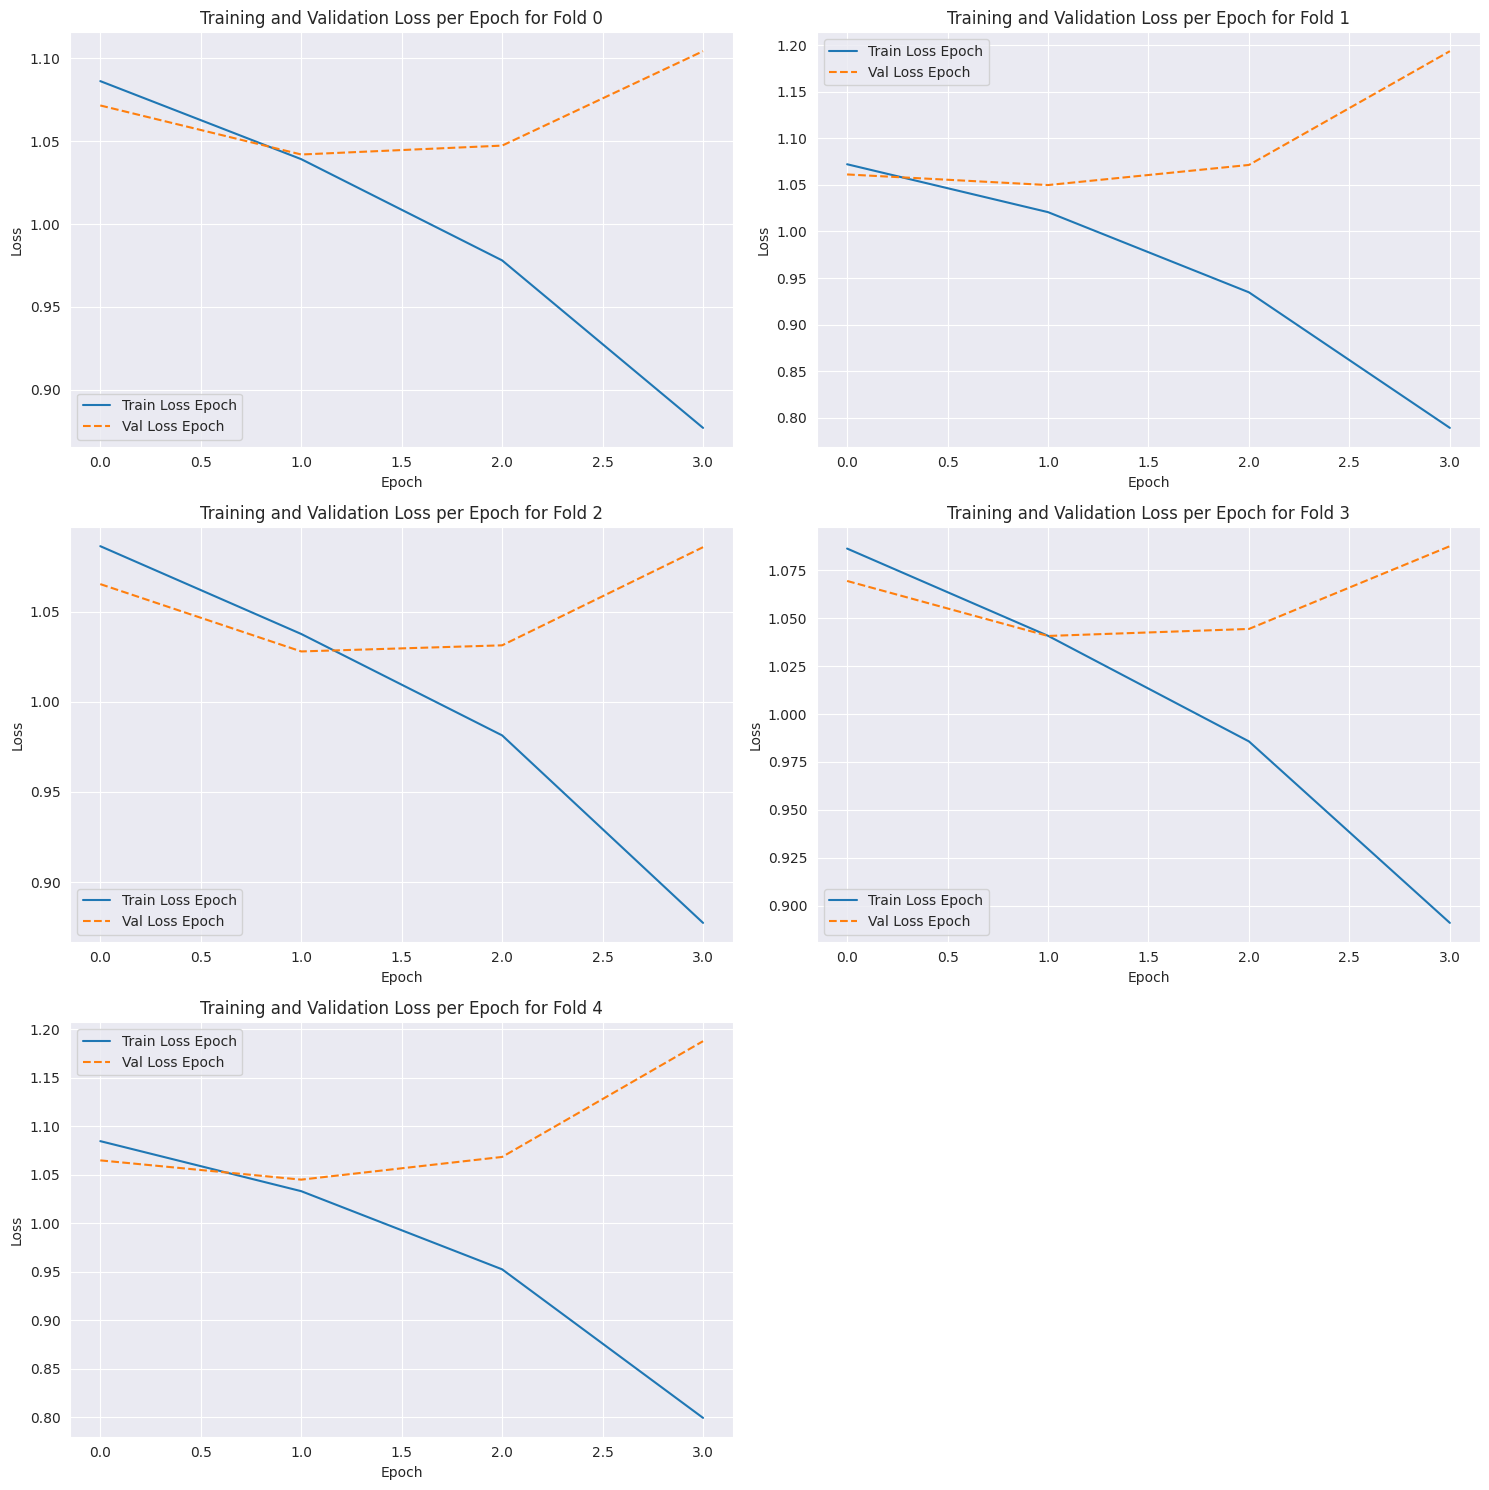

In [ ]:
# Plot logs for different fold
num_folds = len(df_logs)
num_cols = 2
num_rows = (num_folds + 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axs = axs.flatten()

for idx, (name, df) in enumerate(df_logs.items()):
    axs[idx].plot(df['epoch'], df['train_loss_epoch'], label='Train Loss Epoch')
    axs[idx].plot(df['epoch'], df['val_loss_epoch'], label='Val Loss Epoch', linestyle='--')
    axs[idx].set_xlabel('Epoch')
    axs[idx].set_ylabel('Loss')
    axs[idx].set_title(f'Training and Validation Loss per Epoch for Fold {idx}')
    axs[idx].legend()

for i in range(idx + 1, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

The training loss decreases consistently across epochs for all folds, which indicates that the model is learning during the training process and successfully minimizing the error on the training set. While the validation loss initially decreases slightly or stays constant, but then starts increasing that indicates potential overfitting. By epoch 2 or 3, validation loss increases significantly while training loss continues to decreases. Overall, the model displayed effective learning during training. However, the validation loss did not decrease as significantly, suggesting that the model could improve in generalization and better handle unseen data.


In [ ]:
# Identify the best fold
best_fold = None
best_val_loss = float('inf')

for name, df in df_logs.items():
    if df['val_loss_epoch'].iloc[-1] < best_val_loss:
        best_val_loss = df['val_loss_epoch'].iloc[-1]
        best_fold = name

print(f"Best fold: {best_fold} with validation loss: {best_val_loss}")

Best fold: df_log_fold_2 with validation loss: 1.0857349634170532


In [ ]:
best_fold_index = int(best_fold.split('_')[-1])
checkpoint_path = f'/content/model_fold_{best_fold_index}.ckpt'

______
## 5. Conclusions and Discussions
______



This project successfully implemented a transformer-based model to predict user preferences between chatbot responses. While the model demonstrated promising results, especially in training performance, the validation outcomes suggested opportunities for improvement. By addressing these areas through techniques like hyperparameter tuning, regularization, data augmentation, and exploring more advanced architectures, the model's performance can be significantly enhanced, leading to more accurate predictions in real-world applications.

Although the model performed well, several aspects can be improved further. Fine-tuning hyperparameters such as learning rate, batch size, and weight decay could yield better outcomes, and methods like grid search or Bayesian optimization may help identify the optimal settings. Implementing additional regularization techniques such as dropout or adjusting weight decay parameters could prevent overfitting. Augmenting the training data through approaches like back-translation or synonym replacement may boost the model's generalization abilities. Additionally, combining predictions from multiple models (ensemble learning) could enhance performance by reducing variance and bias.

Exploring larger or more advanced transformer models, or fine-tuning on datasets similar to the target task, could also lead to improvements. Extending the number of training epochs or using early stopping to monitor validation loss could help the model converge more effectively and avoid overfitting, ultimately enhancing its performance.

